# Get a LSST Simulated Cadence for Arbitrary Sky Position
___


___

In [2]:
"""

"""
# %matplotlib inline
%matplotlib notebook


from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 
from matplotlib import colorbar as mpl_colorbar
from matplotlib import rc
rc('text', usetex=True)

import os
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord

import lsst_tools.utils as utils 
import lsst_tools.utils.colours as colours 

from multiprocessing import Pool, cpu_count
from contextlib import closing

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [3]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
# opsimdbpath = os.environ.get('OPSIMDBPATH')
# print(opsimdbpath)
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

In [4]:
opsimdf

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,1,1016,54,316,1.676483,-1.082473,y,2922,59580.033829,0,...,0.000000,105.610378,0.920473,0.0,0.0,1.620307,0.000000,21.021236,1.643930,-1.108924
1,2,1016,54,372,1.694120,-1.033972,y,2961,59580.034275,0,...,0.000000,105.167017,0.920473,0.0,0.0,0.049266,4.574944,21.026646,1.664257,-1.060423
2,3,1016,54,441,1.708513,-0.985271,y,2999,59580.034722,0,...,0.000000,104.849578,0.920473,0.0,0.0,0.049298,4.595615,21.030520,1.680878,-1.011722
3,4,1016,54,505,1.720374,-0.936476,y,3038,59580.035169,0,...,0.000000,104.669398,0.920473,0.0,0.0,0.049266,4.605366,21.032718,1.694604,-0.962927
4,5,1016,54,587,1.730248,-0.887672,y,3077,59580.035616,0,...,0.000000,104.627207,0.920473,0.0,0.0,0.049177,4.604023,21.033233,1.706054,-0.914123
5,6,1016,54,680,1.738574,-0.838921,y,3115,59580.036062,0,...,0.000000,104.725606,0.920473,0.0,0.0,0.049050,4.592226,21.032033,1.715721,-0.865372
6,7,1016,54,770,1.745690,-0.790249,y,3154,59580.036509,0,...,0.000000,104.967791,0.920473,0.0,0.0,0.048916,4.571504,21.029077,1.723987,-0.816700
7,8,1016,54,857,1.751878,-0.741640,y,3192,59580.036955,0,...,0.000000,105.357944,0.920473,0.0,0.0,0.048813,4.543796,21.024316,1.731166,-0.768091
8,9,1016,54,957,1.757386,-0.693017,y,3231,59580.037401,0,...,0.000000,105.906574,0.920473,0.0,0.0,0.048800,4.511985,21.017621,1.737535,-0.719468
9,10,1016,54,1021,1.700932,-0.658150,y,3270,59580.037847,0,...,0.000000,102.700018,0.920473,0.0,0.0,0.056177,4.607643,21.056753,1.681628,-0.684601


In [5]:
len(opsimdf["fieldID"].unique())

3339

In [6]:
#%%timeit ## The slowest run took 39.04 times longer than the fastest. This could mean that an intermediate result is being cached.
#         ## 1000 loops, best of 3: 246 µs per loop
n = 1
pos_df = utils.generate_coordinates(n)

Add extinction to the dataframe

In [7]:
#%%timeit ## 1 loop, best of 3: 88.6 ms per loop
df = utils.find_MW_extinction(pos_df) 

Check the positions are sensible

<IPython.core.display.Javascript object>


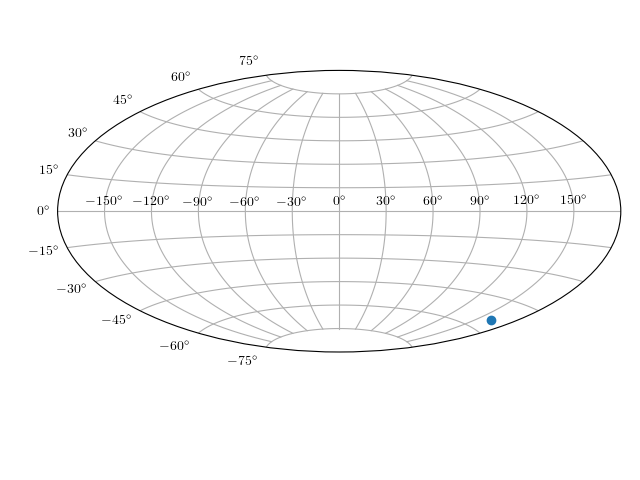

In [8]:
#%%timeit ## 1 loop, best of 3: 235 ms per loop
utils.plot_position_points(df)

Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [9]:
working_df = opsimdf

## Identifying Fields
___
We want to find out which field(s) the position is in. Create table that tells us the field centres, and find the edges.

In [10]:
# working_df = utils.get_field_corners(working_df.drop_duplicates("fieldID"))[['fieldRA', 'fieldDec']]
working_df = utils.get_field_corners(pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec']])

In [11]:
working_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
0,316,1.676483,-1.082473,1.707026,1.645940,-1.113016,-1.051930
1,372,1.694120,-1.033972,1.724663,1.663577,-1.064515,-1.003429
2,441,1.708513,-0.985271,1.739056,1.677970,-1.015814,-0.954728
3,505,1.720374,-0.936476,1.750917,1.689831,-0.967019,-0.905933
4,587,1.730248,-0.887672,1.760791,1.699705,-0.918215,-0.857129
5,680,1.738574,-0.838921,1.769117,1.708031,-0.869464,-0.808378
6,770,1.745690,-0.790249,1.776233,1.715147,-0.820792,-0.759706
7,857,1.751878,-0.741640,1.782421,1.721335,-0.772183,-0.711097
8,957,1.757386,-0.693017,1.787929,1.726843,-0.723560,-0.662474
9,1021,1.700932,-0.658150,1.731475,1.670389,-0.688693,-0.627607


In [12]:
field_df = working_df[(working_df["RA_upper"] >= df["theta"][0] + np.pi) &
                (working_df["RA_lower"] <= df["theta"][0] + np.pi) &
                (working_df["Dec_lower"] >= df["phi"][0])  &
                (working_df["Dec_upper"] <= df["phi"][0])]

<IPython.core.display.Javascript object>


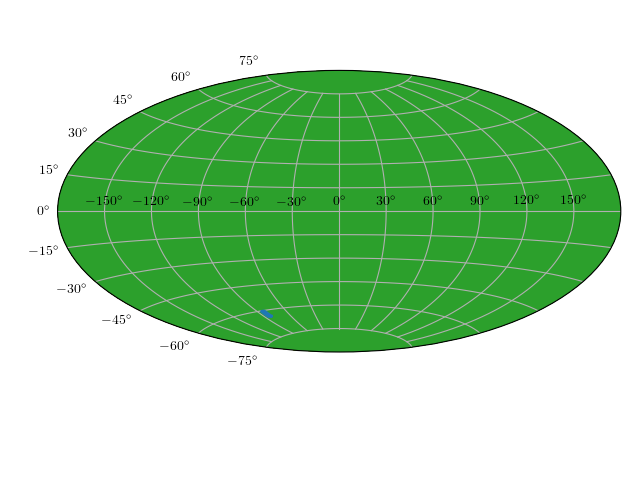

In [13]:
reload(utils)
utils.plot_field(working_df)

In [14]:
df = opsimdf

In [15]:
## Work out how often each field is visited
min_visits = df["fieldID"].value_counts().min()
max_visits = df["fieldID"].value_counts().max()

print(min_visits, ",",max_visits)

df['count'] = df.groupby('fieldID').cumcount()

180 , 24853


In [16]:
ddf = [1427,744,2412,290,2786  ]

In [17]:
cmap = plt.get_cmap("viridis")
# df["cmap_visit_value"] = (df["count"] - min_visits )/(max_visits - min_visits)
df["cmap_visit_value"] = np.log((df["count"] + 1)/(max_visits+1))

In [18]:
df["cmap_visit_value"] = df["cmap_visit_value"] + np.abs(df["cmap_visit_value"].min())
df["cmap_visit_value"] = df["cmap_visit_value"]/df["cmap_visit_value"].max()

In [19]:
df["cmap_visit_value"].hist(bins = 200)

In [20]:
df["fieldID"].value_counts().hist(bins = 200, range = [0, 2000])

In [21]:
df = utils.get_field_corners(df)

In [22]:
night_group = df.groupby("night")

In [23]:
#TEST
# i = 0
# group = night_group.groups[0]
# outpath = "/Users/berto/plots/LSST/cadence/minion/skymap_night_"
# fig = plt.figure()
# fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
#                     right = 0.97, hspace=0, wspace = .1)

# ax_aitoff = fig.add_subplot(111, projection="aitoff")
# ax_aitoff.grid(True)
# ax_aitoff.scatter(df["fieldRA"][group] - np.pi, df["fieldDec"][group], color = cmap(df["cmap_visit_value"][group]))
# fig.savefig(outpath + str(i)+".pdf", format = 'pdf', dpi=500)
# plt.close()

In [24]:
# for group in night_group.groups:
#     print(night_group.groups[0])

In [25]:
df_to_plot = df[["fieldID", "fieldRA", "fieldDec", "cmap_visit_value"]]
df_to_plot["zorder"] = df_to_plot["fieldID"]*0
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 99

/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [26]:
df_to_plot.loc[night_group.groups[0]]

,fieldID,fieldRA,fieldDec,cmap_visit_value,zorder
0,316,1.676483,-1.082473,0.000000,0
1,372,1.694120,-1.033972,0.000000,0
2,441,1.708513,-0.985271,0.000000,0
3,505,1.720374,-0.936476,0.000000,0
4,587,1.730248,-0.887672,0.000000,0
5,680,1.738574,-0.838921,0.000000,0
6,770,1.745690,-0.790249,0.000000,0
7,857,1.751878,-0.741640,0.000000,0
8,957,1.757386,-0.693017,0.000000,0
9,1021,1.700932,-0.658150,0.000000,0


In [27]:
x = len(night_group.groups)

In [28]:
str('%05d' % x)

'03026'

In [29]:
df_to_plot

,fieldID,fieldRA,fieldDec,cmap_visit_value,zorder
0,316,1.676483,-1.082473,0.000000,0
1,372,1.694120,-1.033972,0.000000,0
2,441,1.708513,-0.985271,0.000000,0
3,505,1.720374,-0.936476,0.000000,0
4,587,1.730248,-0.887672,0.000000,0
5,680,1.738574,-0.838921,0.000000,0
6,770,1.745690,-0.790249,0.000000,0
7,857,1.751878,-0.741640,0.000000,0
8,957,1.757386,-0.693017,0.000000,0
9,1021,1.700932,-0.658150,0.000000,0


In [30]:
# def plot_obs(df):
#     outpath = "/Users/berto/plots/LSST/cadence/minion/Test_skymap_night_"

#     df_to_plot = df[["fieldID", "fieldRA", "fieldDec", "cmap_visit_value"]]
#     df_to_plot["zorder"] = df_to_plot["fieldID"]*0
#     df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 99

#     norm = mpl_colors.LogNorm(vmin=max_visits, vmax=min_visits)


#     for i, group in enumerate(np.arange(10)):
#     # for i, group in enumerate(night_group.groups):

#         if i == 0:
#             fig = plt.figure()
#             fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
#                                 right = 0.97, hspace=0, wspace = .1)

#     #         ax_aitoff = fig.add_subplot(111, projection="aitoff")      
#             ax_aitoff = plt.subplot2grid((1,24), (0,0), colspan = 22, rowspan = 1, projection="aitoff")
#             ax_aitoff.grid(True)
#             ax_cbar = plt.subplot2grid((1,24), (0,22), colspan = 1, rowspan = 1)
#     #         ax_active = fig.add_subplot(111, projection="aitoff")


#             working_df_to_plot = df_to_plot.loc[night_group.groups[group]]
#         else:
#             working_df_to_plot = pd.concat([working_df_to_plot,df_to_plot.loc[night_group.groups[group]]])
#             working_df_to_plot.drop_duplicates(subset=['fieldID'], inplace=True, keep="last")

#     #     ax_aitoff.scatter(working_df_to_plot["fieldRA"][night_group.groups[group]] - np.pi, 
#     #               working_df_to_plot["fieldDec"][night_group.groups[group]], 
#     #               color = cmap(working_df_to_plot["cmap_visit_value"][night_group.groups[group]]))

#         ax_aitoff.scatter(working_df_to_plot["fieldRA"] - np.pi, 
#                           working_df_to_plot["fieldDec"], 
#                           color = cmap(working_df_to_plot["cmap_visit_value"]))

#         ax_aitoff.scatter(working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldRA"]] - np.pi, 
#                           working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldDec"]], 
#                           color = cmap(working_df_to_plot[working_df_to_plot["zorder"] == 99]["cmap_visit_value"])
#                           )

#     #     fig_cont = fig

#     #     ax_active.scatter(working_df_to_plot["fieldRA"] - np.pi, 
#     #                       working_df_to_plot["fieldDec"], 
#     #                       color = cmap(working_df_to_plot["cmap_visit_value"]),
#     #                       linewidths = 0.5 , edgecolors = colours.hex["black"])

#         cb1 = mpl_colorbar.ColorbarBase(ax_cbar, cmap=cmap,
#                                     norm=norm)
#         fig.savefig(outpath + str('%05d' % i)+".png", format = 'png', dpi=200)

#     #     ax_active.clear()
#     #     print(len(working_df_to_plot))
#     # plt.close()

In [ ]:
df_to_plot = df[["fieldID", "fieldRA", "fieldDec", "cmap_visit_value"]]

# outpath = "/Users/berto/plots/LSST/cadence/minion/Test_skymap_night_"
outpath = os.path.join(os.environ["HOME"], "plots/LSST/cadence/minion_real/skymap_night_")

df_to_plot["zorder"] = df_to_plot["fieldID"]*0
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 99
norm = mpl_colors.LogNorm(vmin=max_visits, vmax=min_visits)


# for i, group in enumerate(np.arange(4)):
for i, group in enumerate(night_group.groups):

    if i == 0:
        fig = plt.figure()
        fig.subplots_adjust(left = 0.05, bottom = 0.05, top = 0.99,
                            right = 0.97, hspace=0, wspace = .1)
    
#         ax_aitoff = plt.subplot2grid((1,24), (0,0), colspan = 22, rowspan = 1, projection="aitoff")
#         ax_aitoff.grid(True)
#         ax_active = plt.subplot2grid((1,24), (0,0), colspan = 22, rowspan = 1, projection="aitoff")
#         ax_active.grid(True)
    
        ax_aitoff = fig.add_subplot(111, projection = "aitoff")
        ax_active = fig.add_subplot(111, projection = "aitoff")
        ax_aitoff.grid(True)
        ax_active.grid(True)
        ax_aitoff.set_xticklabels(['$2^h$','$4^h$','$6^h$', '$8^h$', '$10^h$', '$12^h$',
                                  '$14^h$','$16^h$','$18^h$','$20^h$','$22^h$'], fontsize=10)
        ax_active.set_xticklabels(['$2^h$','$4^h$','$6^h$', '$8^h$', '$10^h$', '$12^h$',
                                  '$14^h$','$16^h$','$18^h$','$20^h$','$22^h$'], fontsize=10)
#         ax_cbar = plt.subplot2grid((1,24), (0,22), colspan = 1, rowspan = 1)
        ax_cbar = fig.add_subplot(20,1,19)
        cb1 = mpl_colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                norm=norm, orientation='horizontal')
        cb1.set_label(r'$\textnormal{Number of Visits}$')
        
        working_df_to_plot = df_to_plot.loc[night_group.groups[group]]

    else:
#         ax_active = fig.add_subplot(111, projection = "aitoff")
        working_df_to_plot = pd.concat([working_df_to_plot,df_to_plot.loc[night_group.groups[group]]])
    
        working_df_to_plot.drop_duplicates(subset=['fieldID'], inplace=True, keep="last")
    
    s = r"$\textnormal{night} = " + str(i) + "$"
    txt = plt.figtext(0.85, 0.8, s)
        
    s1 = ax_aitoff.scatter(working_df_to_plot["fieldRA"] - np.pi, 
                      working_df_to_plot["fieldDec"], 
                      color = cmap(working_df_to_plot["cmap_visit_value"]))

    
    s2 = ax_aitoff.scatter(working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldRA"]] - np.pi, 
                      working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldDec"]], 
                      color = cmap(working_df_to_plot[working_df_to_plot["zorder"] == 99]["cmap_visit_value"])
                      )
    
    s_a = ax_active.scatter(df_to_plot.loc[night_group.groups[group]]["fieldRA"] - np.pi, 
                      df_to_plot.loc[night_group.groups[group]]["fieldDec"], 
                      color = cmap(df_to_plot.loc[night_group.groups[group]]["cmap_visit_value"]),
                      edgecolor = colours.hex["black"])


    plt.draw()
    fig.savefig(outpath + str('%05d' % i)+".png", format = 'png', dpi=200)
    s_a.remove()
    txt.remove()

/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-co

<IPython.core.display.Javascript object>

In [ ]:
ones = np.ones(10)

In [ ]:
len(ones[0:])

In [ ]:
working_df_to_plot[working_df_to_plot["zorder"] == 99]["cmap_visit_value"]

In [ ]:
df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldRA"]]

In [ ]:
# working_df_to_plot["fieldID"] in df_to_plot["fieldID"]
# df1 = working_df_to_plot.head(10)
# df2 = working_df_to_plot.tail(10)
df1 = df_to_plot.loc[df_to_plot["fieldID"] == 505].head(1)
df2 = df_to_plot.loc[df_to_plot["fieldID"] == 505].tail(1)

In [ ]:
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 1

In [ ]:
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)]

In [ ]:
df2

In [ ]:
df1

In [ ]:
df3 = pd.concat([df1,df2])

In [ ]:
df3

In [ ]:
df3.drop_duplicates(subset=['fieldID'], inplace=True, keep="last")

In [ ]:
df3

In [ ]:
df.loc[df["fieldID"] == 505].head(10)

In [ ]:
# outpath = "/Users/berto/plots/LSST/cadence/minion/skymap_"


# for row in df.iterrows():
#     fig = plt.figure()
#     fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
#                         right = 0.97, hspace=0, wspace = .1)

#     ax_aitoff = fig.add_subplot(111, projection="aitoff")
#     ax_aitoff.grid(True)
#     ax_aitoff.scatter(row["fieldRA"] - np.pi, row["fieldDec"], color = cmap(row[cmap_visit_value]))
    
#     fig.savefig(outpath + row["obsHistID"]+".pdf", format = 'pdf', dpi=500)

In [ ]:
data = {}
x = np.arange(10)

for i in np.arange(5):
    data[str(i)] = np.random.random(10)

outpath = "/Users/berto/plots/LSST/cadence/test_"

for i, j in enumerate(data):
    if i == 0:
        fig = plt.figure()
        fig.subplots_adjust(left = 0.05, bottom = 0.01, top = 0.99,
                            right = 0.97, hspace=0, wspace = .1)

        ax = fig.add_subplot(111, projection = "aitoff")
        ax_active = fig.add_subplot(111, projection = "aitoff")
        
    else:
        pass
    
    s1 = ax.scatter(x, data[j], color = colours.hex["pomegranite"])
    s2 = ax_active.scatter(x, data[j], color = colours.hex["pomegranite"], edgecolor = "black")
    
    fig.savefig(outpath + str('%05d' % i)+".png", format = 'png', dpi=200)
    s2.remove()
